## Image rectification

Text(0.5, 1.0, 'Detected lines')

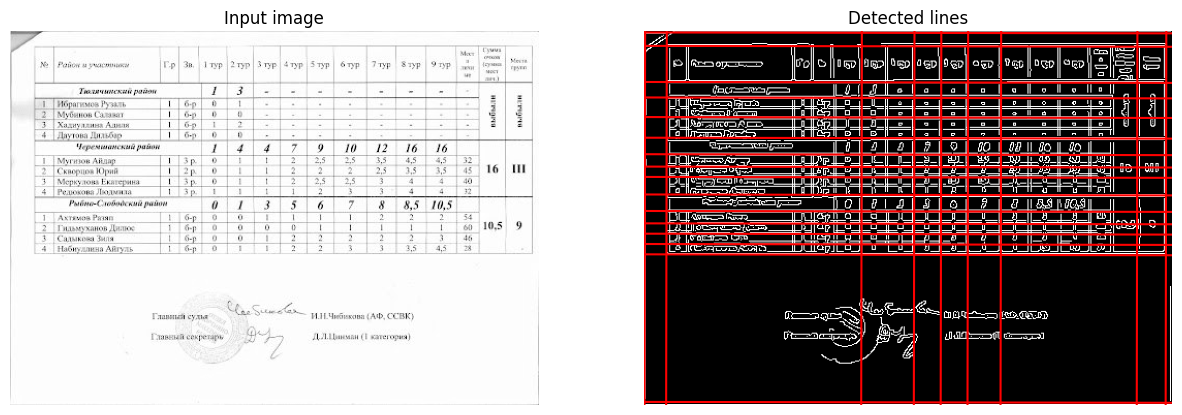

In [22]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode

img_name = 'table.jpg'
path = '/content/images/'
image = rgb2gray(imread(path + img_name))

edges = canny(image)
tested_angles = np.deg2rad(np.arange(0.1, 180.0))
h, theta, d = hough_line(edges, theta=tested_angles)

fig, axes = plt.subplots(1, 2, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')

ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

Rotated on: -0.04562616446074916


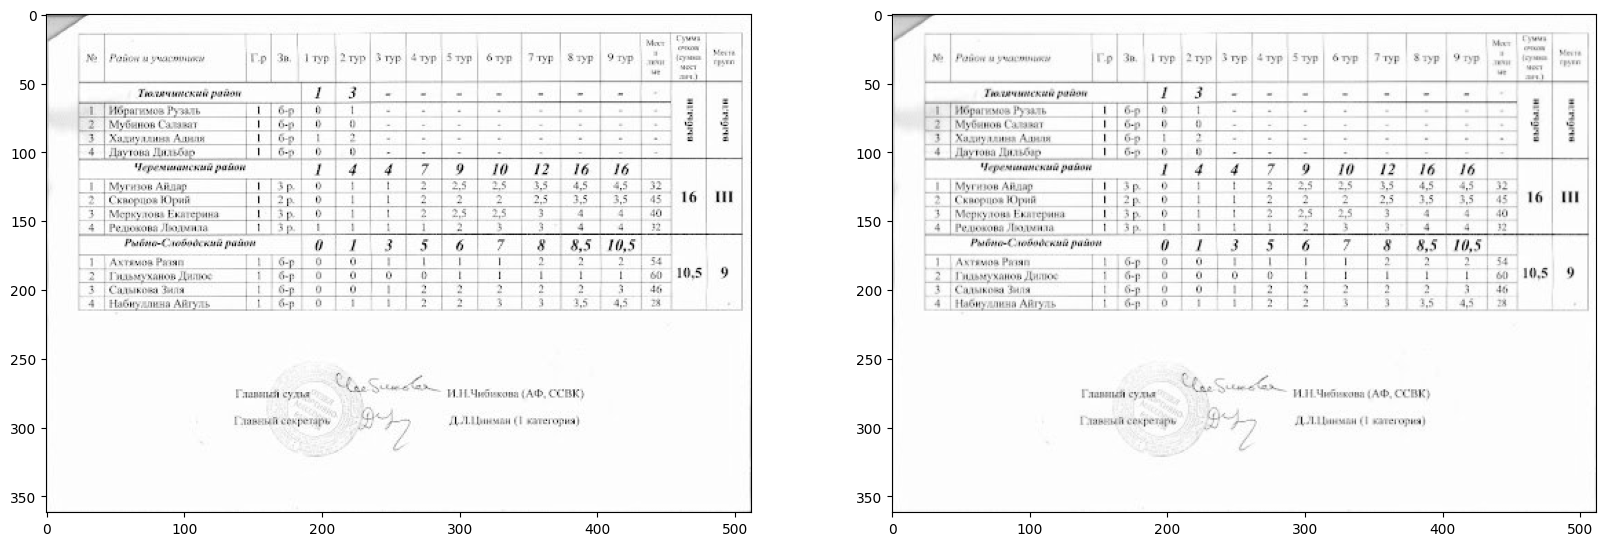

In [23]:
def skew_angle_hough_transform(image):
    # convert to edges
    edges = canny(image)
    # classic straight-line Hough transform between 0.1 - 180 degrees.
    tested_angles = np.deg2rad(np.arange(0.1, 180.0))
    h, theta, d = hough_line(edges, theta=tested_angles)

    # find line peaks and angles
    accum, angles, dists = hough_line_peaks(h, theta, d)

    # round the angles to 2 decimal places and find the most common angle.
    most_common_angle = mode(np.around(angles, decimals=2))[0]

    # convert the angle to degree for rotation.
    skew_angle = np.rad2deg(most_common_angle - np.pi/2)
    print(f'Rotated on: {skew_angle}')
    return skew_angle

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
rotated_image = rotate(image, skew_angle_hough_transform(image), cval=1)
ax[0].imshow(image, cmap='gray')
ax[1].imshow(rotated_image, cmap='gray')
plt.show()

(-0.5, 511.5, 361.5, -0.5)

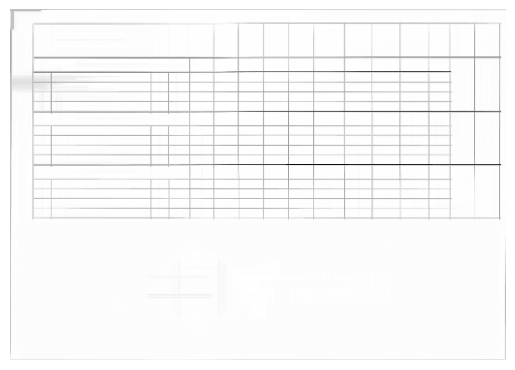

In [24]:
import cv2
import numpy as np

#to get horizontal lines use horizontal structure element
horizontal = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, np.ones((1, 60)))
#to get vertical lines use vertical structure element
vertical = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, np.ones((40, 1)))
# the resulting image is the minimum of both images
table = np.minimum(vertical, horizontal)
plt.imshow(table, cmap='gray')
plt.axis('off')

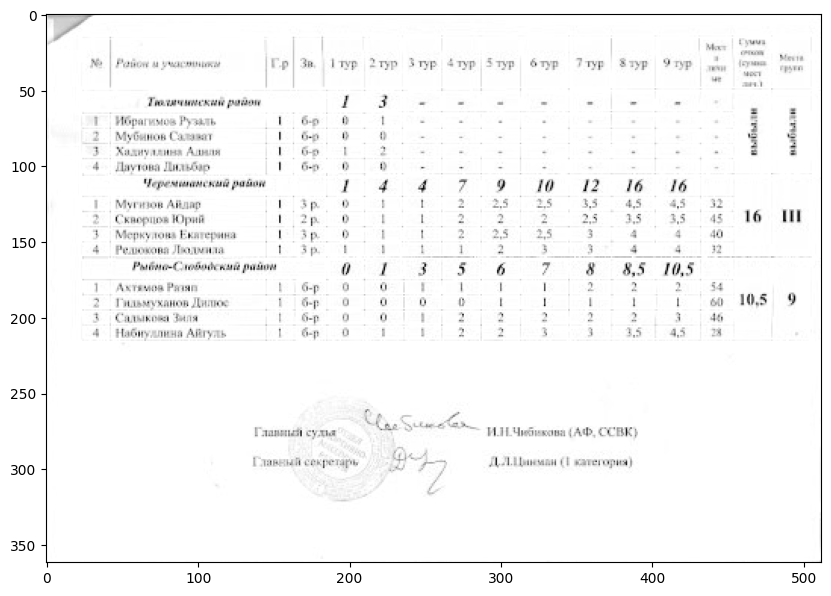

In [25]:

inv_image = cv2.bitwise_not(np.uint8(rotated_image * 255.))
inv_table = cv2.bitwise_not(np.uint8(table * 255.))
broad_table = cv2.dilate(inv_table, np.ones((3, 3)))
float_diff = np.float64(inv_image) - np.float64(broad_table)
inv_img_no_table = np.uint8(np.where(float_diff > 0, float_diff, 0))
img_no_table = cv2.bitwise_not(inv_img_no_table)

fig, ax = plt.subplots(ncols=1, figsize=(10,10))
ax.imshow(img_no_table, cmap='gray')
plt.savefig(path + 'rotated_' + img_name, format='jpg')

In [26]:
import cv2
import glob
import os

path = "/content/images/*.*"
names = [os.path.basename(x) for x in glob.glob(path)]

Rotated on: -0.04562616446074916


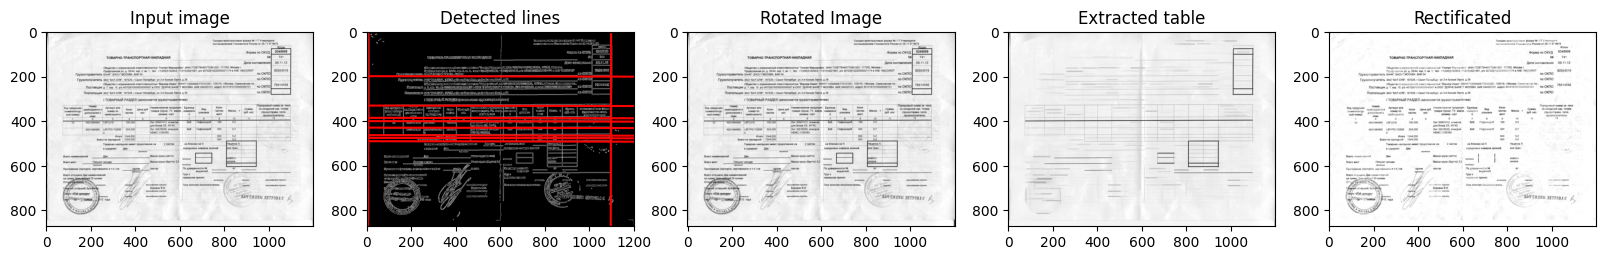

Rotated on: -0.04562616446074916


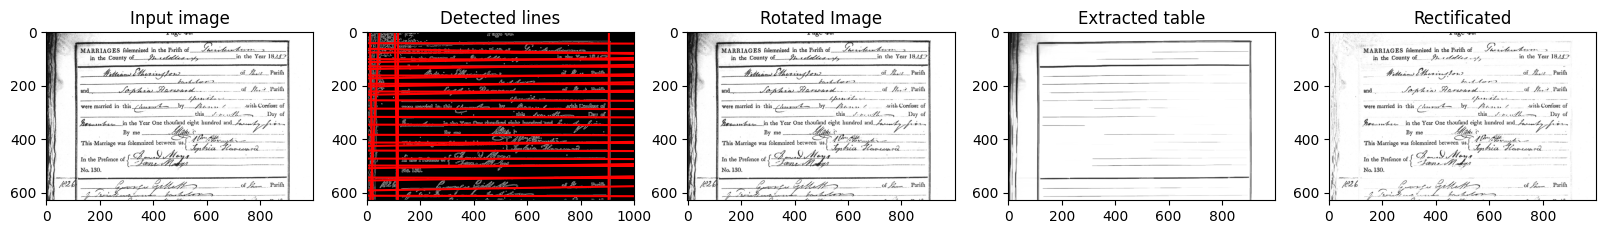

Rotated on: -0.04562616446074916


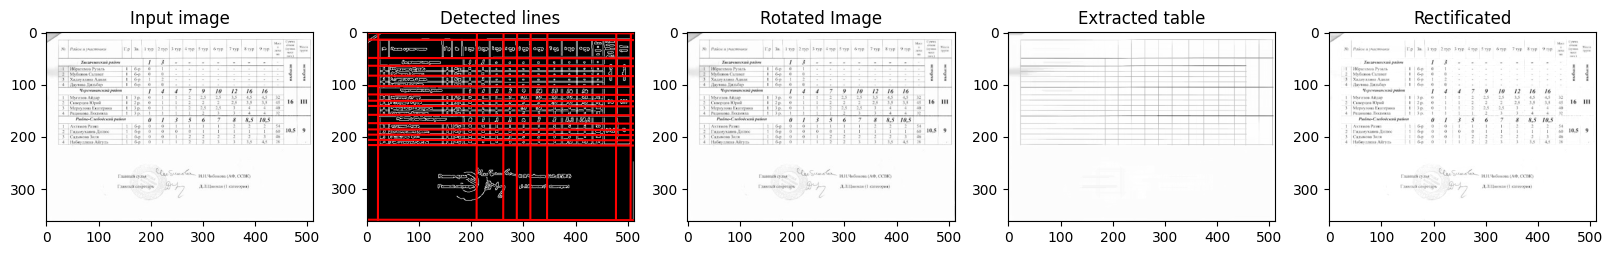

Rotated on: 72.14705602202298


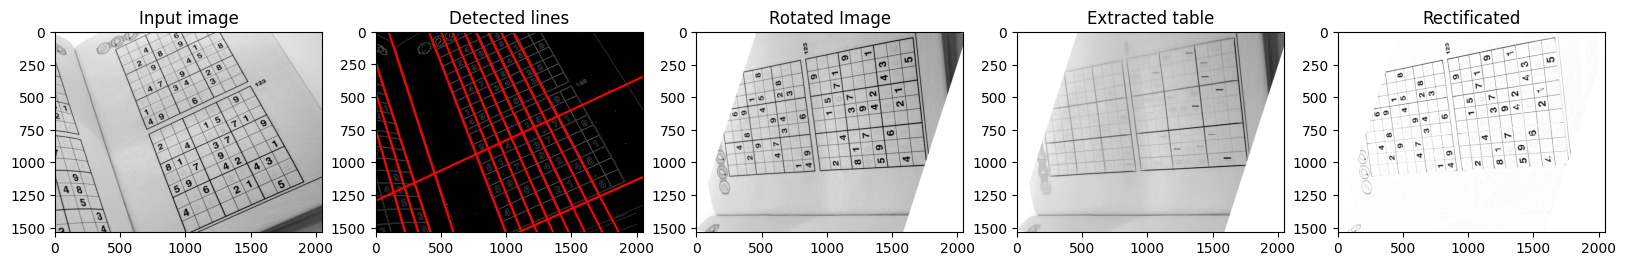

Rotated on: -0.04562616446074916


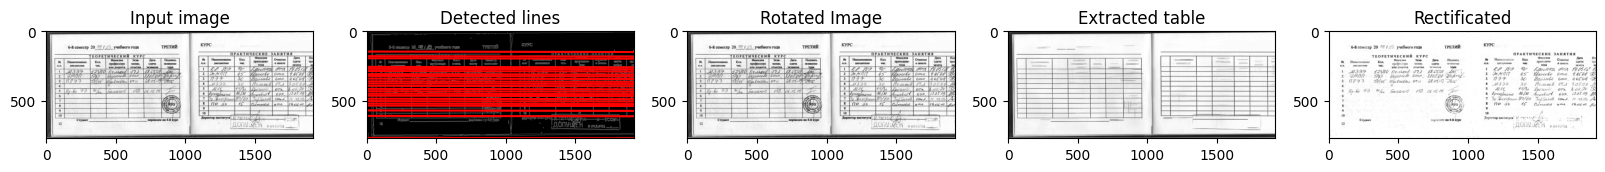

Rotated on: -85.98929543408423


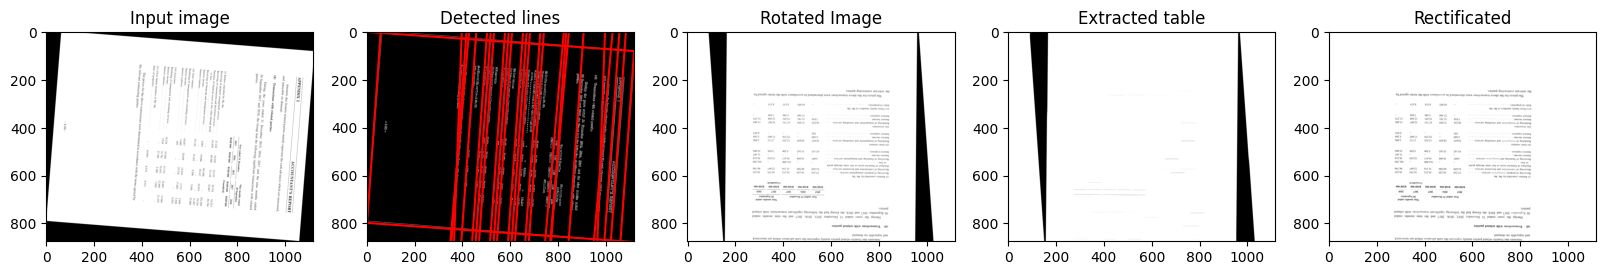

Rotated on: -16.0884444281238


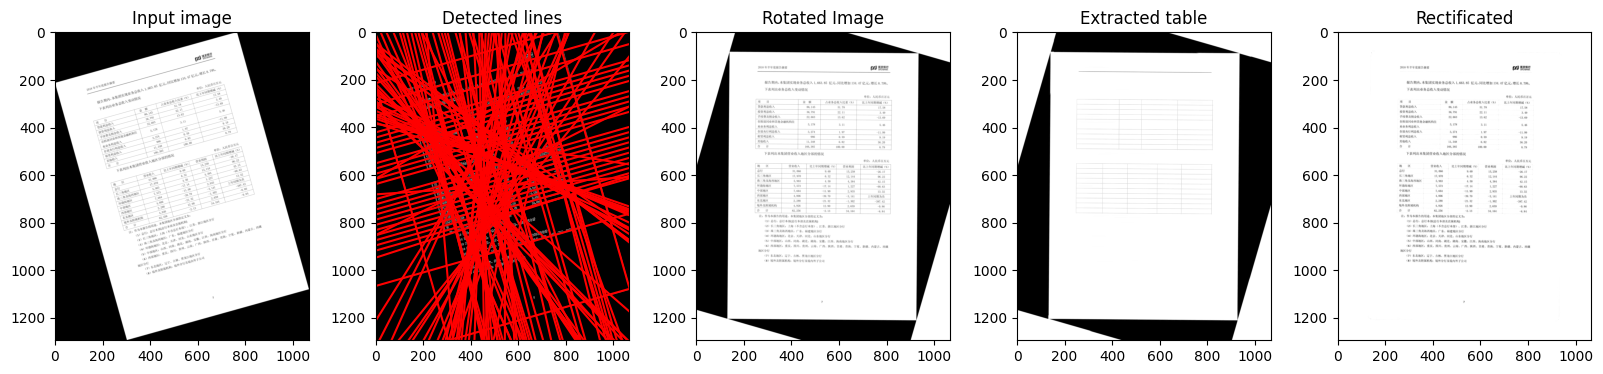

Rotated on: 2.2462050160625457


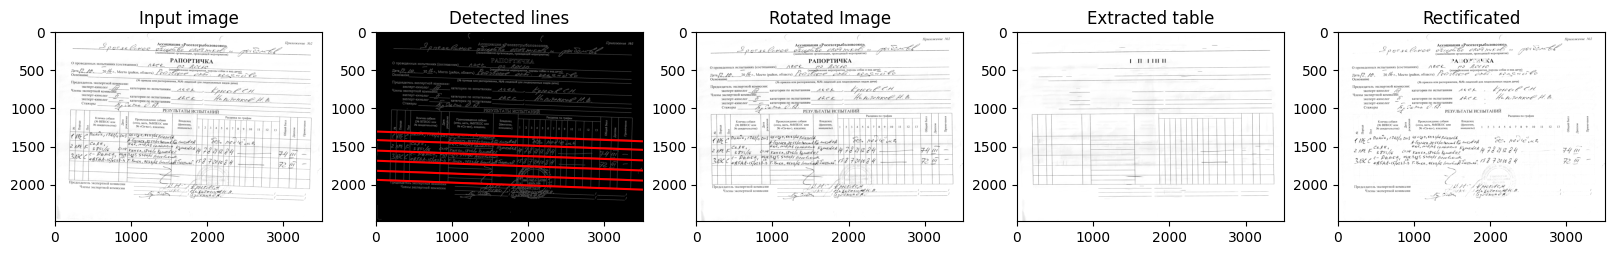

Rotated on: 5.110993991716652


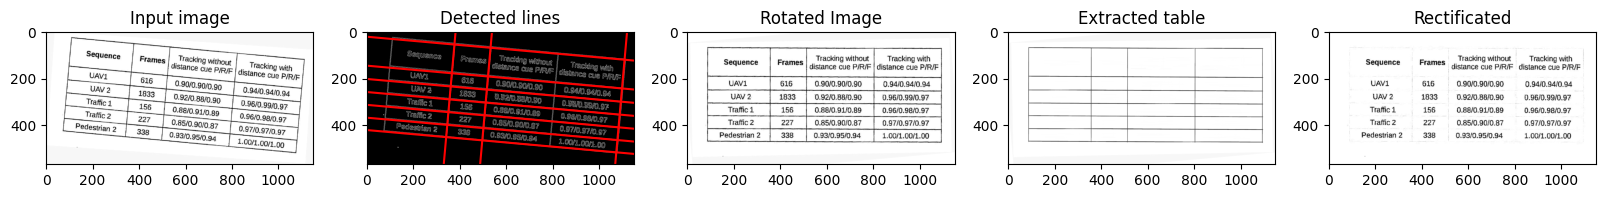

Rotated on: -0.04562616446074916


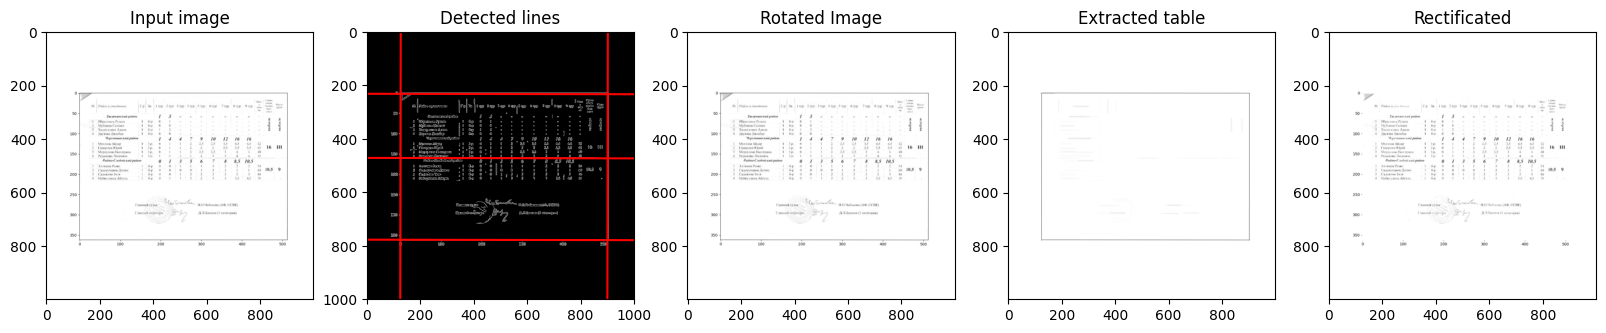

Rotated on: -0.04562616446074916


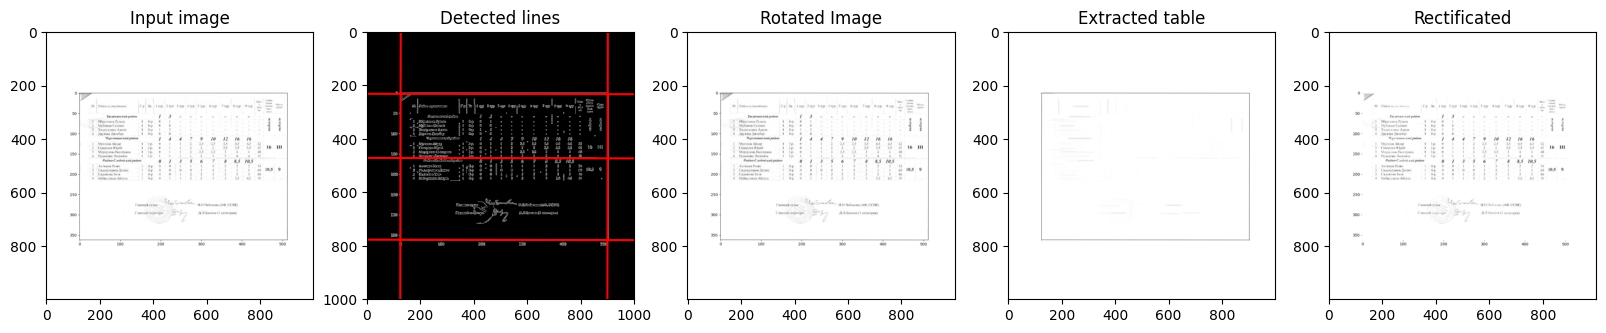

Rotated on: -0.04562616446074916


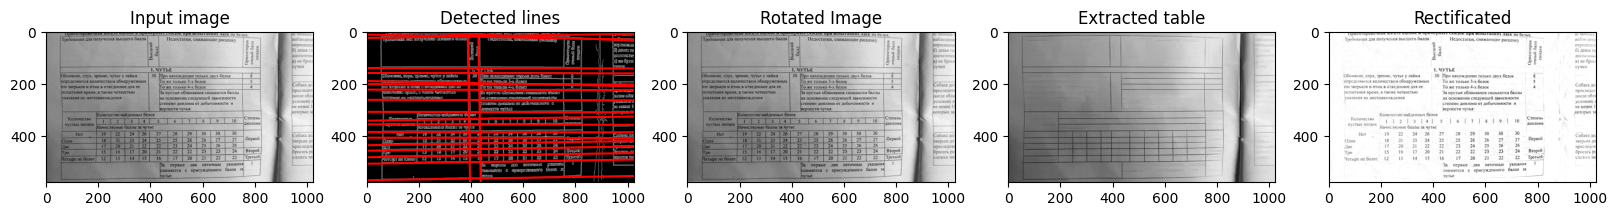

In [27]:
for name in names:
    # get image
    image = rgb2gray(imread('/content/images/'+name))
    # find edges via Canny detector
    edges = canny(image)
    tested_angles = np.deg2rad(np.arange(0.1, 180.0))
    # run HT
    h, theta, d = hough_line(edges, theta=tested_angles)

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    ax = axes.ravel()

    # drawing input image
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title('Input image')

    # drawing hough lines
    ax[1].imshow(edges, cmap="gray")
    origin = np.array((0, image.shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[1].plot(origin, (y0, y1), '-r')
    ax[1].set_xlim(origin)
    ax[1].set_ylim((edges.shape[0], 0))
    ax[1].set_title('Detected lines')

    # choose the highest appearence angle and rotate
    rotated_image = rotate(image, skew_angle_hough_transform(image), cval=1)

    # draw rotated image
    ax[2].imshow(rotated_image, cmap='gray')
    ax[2].set_title('Rotated Image')

    # to get horizontal lines we use horizontal structure element
    horizontal = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, np.ones((1, 50)))
    # to get vertical lines we use vertical structure element
    vertical = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, np.ones((50, 1)))
    # the resulting image is the minimum of both images
    table = np.minimum(vertical, horizontal)
    ax[3].imshow(table, cmap='gray')
    ax[3].set_title('Extracted table')
    # inverted image for further extraction
    inv_image = cv2.bitwise_not(np.uint8(rotated_image * 255.))
    inv_table = cv2.bitwise_not(np.uint8(table * 255.))
    # added dilation operation to broaden the lines of table
    broad_table = cv2.dilate(inv_table, kernel=np.ones((3, 3)))
    # subtract the table
    float_diff = np.float64(inv_image) - np.float64(broad_table)
    inv_img_no_table = np.uint8(np.where(float_diff > 0, float_diff, 0))
    img_no_table = cv2.bitwise_not(inv_img_no_table)
    # draw final image
    ax[4].imshow(img_no_table, cmap='gray')
    ax[4].set_title('Rectificated')
    plt.savefig('rotated_'+name, format='jpg')
    plt.show()